In [179]:
import pandas as pd
import numpy as np
import osmnx as ox
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import time
import geopandas as gpd
from sdv.relational import HMA1


In [180]:
qts2=pd.read_excel('/Users/erensmacbook/Downloads/2qts.xlsx')
qts5=pd.read_excel('/Users/erensmacbook/Downloads/5qts.xlsx')

qts2_t=qts2[['PERSID','AGEGROUP','SEX','WORKSTATUS','INDUSTRY']]
qts2_t=qts2_t[(qts2_t.INDUSTRY.isna() != True)] ## Ogrenci bilgileri icin mainact ve studying later

qts5_t=qts5[['PERSID','TRIPID',
      'ORIGPLACE','ORIGSA1_2021'
     ,'DESTPURP','DESTSA1_2021'
     ,'STARTIME']]

train_data= pd.merge(qts2_t,qts5_t, on='PERSID')
train_data

,PERSID,AGEGROUP,SEX,WORKSTATUS,INDUSTRY,TRIPID,ORIGPLACE,ORIGSA1_2021,DESTPURP,DESTSA1_2021,STARTIME
0,100001/1000,10,female,workFullTime,construction,1000011000001,My home,31603142717,Work (my workplace),31605143413,240
1,100001/1000,10,female,workFullTime,construction,1000011000002,Other work-related place,31605143413,Go home,31603142717,540
2,100001/1001,10,male,workFullTime,construction,1000011001001,My home,31603142717,Work (other work reason),31605143413,240
3,100001/1001,10,male,workFullTime,construction,1000011001002,Other work-related place,31605143413,Go home,31603142717,540
4,100001/1002,5,male,workFullTime,construction,1000011002001,My home,31603142717,Work (other work reason),31605143413,240
...,...,...,...,...,...,...,...,...,...,...,...
54643,99991/1001,12,male,workFullTime,transport,999911001001,My home,30103101509,Just accompanying someone,30501111001,255
54644,99991/1001,12,male,workFullTime,transport,999911001002,Other place (please specify),30501111001,Shopping,30301105142,660
54645,99991/1001,12,male,workFullTime,transport,999911001003,Shop or supermarket,30301105142,Go home,30103101509,750
54646,99991/1003,5,female,workPartTime,health,999911003001,My home,30103101509,Just accompanying someone,30103102031,330


In [5]:
#train_data=train_data[(train_data.ORIGPLACE =='My home') ]
#train_data=train_data[(train_data.DESTPURP =='Work (my workplace)' ) | (train_data.DESTPURP == 'Personal business' )
#            |(train_data.DESTPURP == 'Work (other work reason)' )]
#train_data

,PERSID,AGEGROUP,SEX,WORKSTATUS,INDUSTRY,TRIPID,ORIGPLACE,ORIGSA1_2021,DESTPURP,DESTSA1_2021,STARTIME
0,100001/1000,10,female,workFullTime,construction,1000011000001,My home,31603142717,Work (my workplace),31605143413,240
2,100001/1001,10,male,workFullTime,construction,1000011001001,My home,31603142717,Work (other work reason),31605143413,240
4,100001/1002,5,male,workFullTime,construction,1000011002001,My home,31603142717,Work (other work reason),31605143413,240
6,100001/1003,5,female,workFullTime,accom,1000011003001,My home,31603142717,Work (other work reason),31603142808,360
12,100002/1001,7,female,workFullTime,admin,1000021001001,My home,31603142717,Work (my workplace),31602142324,180
...,...,...,...,...,...,...,...,...,...,...,...
54621,99986/1001,11,male,workFullTime,manufacturing,999861001001,My home,31603142717,Work (my workplace),31601141301,100
54623,99986/1002,5,male,workFullTime,manufacturing,999861002001,My home,31603142717,Work (my workplace),31601141301,100
54625,99990/1000,11,male,workFullTime,other,999901000001,My home,30103101509,Work (my workplace),30504113528,150
54627,99990/1001,4,male,workPartTime,other,999901001001,My home,30103101509,Work (other work reason),30103102002,261


In [181]:
# Set filepath
fp = "/Users/erensmacbook/Downloads/SA1_2021_AUST_SHP_GDA2020/SA1_2021_AUST_GDA2020.shp"

# Read file using gpd.read_file()
data = gpd.read_file(fp)

data1= data[(data.SA4_NAME21=='Brisbane - East') |
   (data.SA4_NAME21=='Brisbane - North')
    |
   (data.SA4_NAME21=='Brisbane - West')
    |
   (data.SA4_NAME21=='Brisbane Inner City')
           |
   (data.SA4_NAME21=='Brisbane - South')]

qld_orig = data1[['SA1_CODE21','geometry']]
qld_dest = data1[['SA1_CODE21','geometry']]

qld_orig=qld_orig.rename(columns={"SA1_CODE21":"ORIGSA1_2021"})
qld_dest=qld_dest.rename(columns={"SA1_CODE21":"DESTSA1_2021"})

qld_orig['ORIGSA1_2021']=qld_orig['ORIGSA1_2021'].astype(int)
qld_dest['DESTSA1_2021']=qld_dest['DESTSA1_2021'].astype(int)

qld_orig=qld_orig.rename(columns={"geometry":"geo_o"})
qld_dest=qld_dest.rename(columns={"geometry":"geo_d"})


train_data = pd.merge(train_data,qld_orig, on="ORIGSA1_2021")
train_data= pd.merge(train_data,qld_dest, on="DESTSA1_2021")



In [182]:
train_data=train_data.sort_values(by=['PERSID', 'STARTIME'])


In [183]:
train_data

,PERSID,AGEGROUP,SEX,WORKSTATUS,INDUSTRY,TRIPID,ORIGPLACE,ORIGSA1_2021,DESTPURP,DESTSA1_2021,STARTIME,geo_o,geo_d
937,100049/1000,10,male,workFullTime,utilities,1000491000002,Primary or secondary school,30403109418,Work (my workplace),30501110537,255,"POLYGON ((152.96149 -27.50792, 152.96172 -27.5...","POLYGON ((153.02875 -27.47226, 153.02868 -27.4..."
753,100049/1000,10,male,workFullTime,utilities,1000491000004,My workplace,30501110537,Pick up or drop off a passenger,30501111032,795,"POLYGON ((153.02875 -27.47226, 153.02868 -27.4...","POLYGON ((153.01364 -27.47022, 153.01383 -27.4..."
4423,100069/1000,14,male,workFullTime,construction,1000691000001,My home,30103101509,Personal business,30502111409,214,"POLYGON ((153.18324 -27.44776, 153.18386 -27.4...","POLYGON ((153.05511 -27.45296, 153.05525 -27.4..."
5151,100069/1000,14,male,workFullTime,construction,1000691000002,Someone else's home,30502111409,Shopping,30301104813,416,"POLYGON ((153.05511 -27.45296, 153.05525 -27.4...","POLYGON ((153.10010 -27.47206, 153.09928 -27.4..."
4424,100069/1000,14,male,workFullTime,construction,1000691000003,Other work-related place,30301104813,Personal business,30502111409,445,"POLYGON ((153.10010 -27.47206, 153.09928 -27.4...","POLYGON ((153.05511 -27.45296, 153.05525 -27.4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5070,99991/1001,12,male,workFullTime,transport,999911001001,My home,30103101509,Just accompanying someone,30501111001,255,"POLYGON ((153.18324 -27.44776, 153.18386 -27.4...","POLYGON ((153.02625 -27.48309, 153.02634 -27.4..."
5455,99991/1001,12,male,workFullTime,transport,999911001002,Other place (please specify),30501111001,Shopping,30301105142,660,"POLYGON ((153.02625 -27.48309, 153.02634 -27.4...","POLYGON ((153.10382 -27.50044, 153.10511 -27.5..."
4754,99991/1001,12,male,workFullTime,transport,999911001003,Shop or supermarket,30301105142,Go home,30103101509,750,"POLYGON ((153.10382 -27.50044, 153.10511 -27.5...","POLYGON ((153.18324 -27.44776, 153.18386 -27.4..."
4782,99991/1003,5,female,workPartTime,health,999911003001,My home,30103101509,Just accompanying someone,30103102031,330,"POLYGON ((153.18324 -27.44776, 153.18386 -27.4...","POLYGON ((153.17560 -27.44572, 153.17626 -27.4..."


In [236]:
#train_data
#fact_index3 =[]
cop=train_data.copy()


#codes, uniques = cop['ORIGSA1_2021'].append(cop['DESTSA1_2021']).factorize(['ORIGSA1_2021'])

#cop['ORIGSA1_2021'] = codes

#fact_index3.append(uniques)

#cop[['ORIGSA1_2021']]=cop[['ORIGSA1_2021']].apply(lambda x: fact_index3[0][x] )




In [237]:
#cop[['ORIGSA1_2021','DESTSA1_2021']] = cop[['ORIGSA1_2021','DESTSA1_2021']].stack().rank(method='dense').unstack()
#stacked = cop[['ORIGSA1_2021','DESTSA1_2021']].stack()
#cop[['ORIGSA1_2021','DESTSA1_2021']] = pd.Series(stacked.factorize()[0], index=stacked.index).unstack()

In [238]:
vals = cop[['ORIGSA1_2021','DESTSA1_2021']].stack().drop_duplicates().values
b = [x for x in cop[['ORIGSA1_2021','DESTSA1_2021']].stack().drop_duplicates().rank(method='dense')]

d1 = dict(zip(vals, b))
d2= dict(zip(b, vals))

In [239]:
d2=dict((int(k),int(v)) for k,v in d2.items())

In [240]:
cop['ORIGSA1_2021'].astype(int).isna().value_counts()

False    16778
Name: ORIGSA1_2021, dtype: int64

In [241]:
cop['DESTSA1_2021']=cop['DESTSA1_2021'].map(d1) 
cop['ORIGSA1_2021']=cop['ORIGSA1_2021'].map(d1) 

conv_des=cop['DESTSA1_2021'].astype(int)
conv_or=cop['ORIGSA1_2021'].astype(int)

cop['DESTSA1_2021'] = conv_des
cop['ORIGSA1_2021'] = conv_or

In [229]:


#cop['DESTSA1_2021']=cop['DESTSA1_2021'].map(d2) 
#cop['ORIGSA1_2021']=cop['ORIGSA1_2021'].map(d2) 

In [143]:
#cop['DESTSA1_2021']=cop['DESTSA1_2021'].map(d2) 
#cop['ORIGSA1_2021']=cop['ORIGSA1_2021'].map(d2)   reverse codes

In [149]:
#indices=list(range(0, len(cop.ORIGSA1_2021.unique())))
#res = dict(zip(indices, uniques))
#reverse_res = dict(zip(uniques,indices))


In [148]:
#cop['ORIGSA1_2021']=cop['ORIGSA1_2021'].map(res)  # to map back
#cop['DESTSA1_2021']=cop['DESTSA1_2021'].map(reverse_res) 
#cop=cop.dropna()
#cop.DESTSA1_2021 = cop.DESTSA1_2021.astype(int)
#cop['DESTSA1_2021']=cop['DESTSA1_2021'].apply(lambda x: x.replace('.0',''))


In [247]:
a=cop.groupby('PERSID')


In [248]:
act_ind=cop.PERSID.unique()

In [249]:
den=a.get_group(act_ind[1]) 
den

,PERSID,AGEGROUP,SEX,WORKSTATUS,INDUSTRY,TRIPID,ORIGPLACE,ORIGSA1_2021,DESTPURP,DESTSA1_2021,STARTIME,geo_o,geo_d
4423,100069/1000,14,male,workFullTime,construction,1000691000001,My home,279,Personal business,1371,214,"POLYGON ((153.18324 -27.44776, 153.18386 -27.4...","POLYGON ((153.05511 -27.45296, 153.05525 -27.4..."
5151,100069/1000,14,male,workFullTime,construction,1000691000002,Someone else's home,1371,Shopping,632,416,"POLYGON ((153.05511 -27.45296, 153.05525 -27.4...","POLYGON ((153.10010 -27.47206, 153.09928 -27.4..."
4424,100069/1000,14,male,workFullTime,construction,1000691000003,Other work-related place,632,Personal business,1371,445,"POLYGON ((153.10010 -27.47206, 153.09928 -27.4...","POLYGON ((153.05511 -27.45296, 153.05525 -27.4..."
4735,100069/1000,14,male,workFullTime,construction,1000691000004,Someone else's home,1371,Go home,279,570,"POLYGON ((153.05511 -27.45296, 153.05525 -27.4...","POLYGON ((153.18324 -27.44776, 153.18386 -27.4..."
4427,100069/1000,14,male,workFullTime,construction,1000691000005,My home,279,Personal business,75,830,"POLYGON ((153.18324 -27.44776, 153.18386 -27.4...","POLYGON ((153.18940 -27.52034, 153.18852 -27.5..."
4736,100069/1000,14,male,workFullTime,construction,1000691000006,Other place (please specify),75,Go home,279,873,"POLYGON ((153.18940 -27.52034, 153.18852 -27.5...","POLYGON ((153.18324 -27.44776, 153.18386 -27.4..."


In [250]:
a.size().value_counts()

2     2543
4      886
3      576
1      437
6      304
5      287
7      119
8       88
9       49
10      32
11      14
12      13
13       3
15       2
16       1
14       1
17       1
dtype: int64

1577

In [251]:
a_of_a=[]
for i in act_ind:
    temp=a.get_group(i)
    templist=temp.ORIGSA1_2021.to_list()
    son=temp.DESTSA1_2021.to_list()[-1]
    templist.append(son)
    templist=list(map(str, templist)) 
    a_of_a.append(templist)
    

    

In [252]:
a_of_a2=[]
for i in act_ind:
    temp=a.get_group(i)
    templist=temp.ORIGSA1_2021.to_list()
    #son=temp.ORIGSA1_2021.to_list()[0]
    #templist.append(son)
    templist=list(map(str, templist)) 
    a_of_a2.append(templist)

In [253]:
a_of_a

[['1137', '1247', '1317'],
 ['279', '1371', '632', '1371', '279', '75', '279'],
 ['279', '288', '279', '281', '279', '288', '279', '344', '279', '288', '279'],
 ['279', '796', '288', '279'],
 ['279', '854', '279'],
 ['279', '321', '279'],
 ['279', '634', '279'],
 ['1257', '1314', '1257'],
 ['1257', '1261', '1257', '1316', '1257'],
 ['1257', '1246', '1257'],
 ['1257', '1290', '1257'],
 ['1257', '1248', '1339', '1257'],
 ['1257', '756', '1257', '1261', '1257'],
 ['1257', '1486', '1257', '1261', '1257'],
 ['1257', '1232', '1257'],
 ['1257', '969', '1257'],
 ['206', '160', '218', '206'],
 ['206', '206', '198', '235', '206'],
 ['206', '206', '198', '235', '206', '206', '206'],
 ['1325', '1242'],
 ['1257', '1446', '1257', '1292', '1257'],
 ['1257', '1555', '1257'],
 ['206', '207', '206'],
 ['206', '168', '151', '206'],
 ['206', '1171', '206'],
 ['206', '140', '206'],
 ['1257', '1232', '1251', '1232', '1241', '1257'],
 ['1257', '1304', '1308', '1257'],
 ['1257', '1582', '1581', '1582', '1257'

In [949]:
# reading from the file
#pd.read_csv("/Users/erensmacbook/Downloads/SeqGAN-PyTorch-master/real.data", sep=" ",index_col=False)



In [254]:
act_df=pd.DataFrame.from_records(a_of_a)

In [255]:
act_df2=pd.DataFrame.from_records(a_of_a2)

In [256]:
act_df=act_df.fillna(0)
act_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,1137,1247,1317,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,279,1371,632,1371,279,75,279,0,0,0,0,0,0,0,0,0,0,0
2,279,288,279,281,279,288,279,344,279,288,279,0,0,0,0,0,0,0
3,279,796,288,279,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,279,854,279,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5351,279,326,274,279,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5352,279,277,279,337,279,277,279,0,0,0,0,0,0,0,0,0,0,0
5353,279,337,279,287,279,1303,676,279,0,0,0,0,0,0,0,0,0,0
5354,279,1303,676,279,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [257]:
act_df2=act_df2.fillna(0)
act_df2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,1137,1247,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,279,1371,632,1371,279,75,0,0,0,0,0,0,0,0,0,0,0
2,279,288,279,281,279,288,279,344,279,288,0,0,0,0,0,0,0
3,279,796,288,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,279,854,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5351,279,326,274,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5352,279,277,279,337,279,277,0,0,0,0,0,0,0,0,0,0,0
5353,279,337,279,287,279,1303,676,0,0,0,0,0,0,0,0,0,0
5354,279,1303,676,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [220]:

cols=list(map(str, range(0,18)))
act_df.columns = cols


In [221]:
train_seq=act_df[['0','1','2','3','4','5','6']]

In [306]:
train_short = train_seq[['0','1','2','3']]
train_short

,0,1,2,3
0,1137,1247,1317,0
1,279,1371,632,1371
2,279,288,279,281
3,279,796,288,279
4,279,854,279,0
...,...,...,...,...
5351,279,326,274,279
5352,279,277,279,337
5353,279,337,279,287
5354,279,1303,676,279


In [384]:
writePath='/Users/erensmacbook/Downloads/SeqGAN-PyTorch-master-2/a.txt'

with open(writePath, 'a') as f:
    dfAsString = train_short.to_string(header=False, index=False)
    f.write(dfAsString)

In [268]:
max(cop.DESTSA1_2021)

1614

In [962]:
#act_df['2'].map(res) 


In [287]:
### #### ####                                                                    ### #### ####
### #### ####                                                                    ### #### ####
### #### ####                                                                    ### #### ####


                                    # Train Results #

### #### ####                                                                    ### #### ####
### #### ####                                                                    ### #### ####
### #### ####                                                                    ### #### ####

In [360]:
syn_seq_prev = syn_seq.copy()

In [369]:
syn_seq=pd.read_csv("/Users/erensmacbook/Downloads/SeqGAN-PyTorch-master-2/gene.data", sep=" ",header=None)
cols=list(map(str, range(0,4)))
syn_seq.columns = cols


In [370]:
syn_seq['0']=syn_seq['0'].map(d2)
syn_seq['1']=syn_seq['1'].map(d2)
syn_seq['2']=syn_seq['2'].map(d2)
syn_seq['3']=syn_seq['3'].map(d2)
#syn_seq['4']=syn_seq['4'].map(res)
#syn_seq['5']=syn_seq['5'].map(res)
#syn_seq['6']=syn_seq['6'].map(res)



In [371]:
syn_seq= syn_seq[syn_seq['0'].ne(0)].reset_index()
syn_seq= syn_seq[syn_seq['1'].ne(0)].reset_index()##remove all 0 gens


In [372]:
d2[0]=0

In [373]:
dests=[]
rang = range(0,len(syn_seq))

for i in rang:
    hm=syn_seq.loc[i].tolist()
    ind=np.max( np.nonzero( syn_seq.loc[i].tolist()))
    dests.append(hm[ind])


#hm=syn_seq.loc[5308].tolist()
#ind=np.max( np.nonzero( syn_seq.loc[5308].tolist()))

#hm[ind]


In [374]:
syn_od = pd.DataFrame()
#real_od = pd.DataFrame()

syn_od['ORIGSA1_2021'] =syn_seq['0']
syn_od['DESTSA1_2021'] =dests


In [375]:
syn_od

,ORIGSA1_2021,DESTSA1_2021
0,30102101229,30504113528
1,30101100403,30102100710
2,30101100334,30302105803
3,30305107217,30305107630
4,30403109615,30102101214
...,...,...
6236,30404110122,30301105127
6237,30102101229,30101100407
6238,30306108025,30306107918
6239,30403109506,30203103513


In [310]:
train_short


,0,1,2,3
0,30403109418,30501110537,30501111032,0
1,30103101509,30502111409,30301104813,30502111409
2,30103101509,30103101601,30103101509,30103101511
3,30103101509,30303106043,30103101601,30103101509
4,30103101509,30303106525,30103101509,0
...,...,...,...,...
5351,30103101509,30103102002,30103101401,30103101509
5352,30103101509,30103101505,30103101509,30103102031
5353,30103101509,30103102031,30103101509,30103101519
5354,30103101509,30501111001,30301105142,30103101509


In [309]:
train_short['0']=train_short['0'].astype(int)
train_short['0']=train_short['0'].map(d2)
train_short['1']=train_short['1'].astype(int)
train_short['1']=train_short['1'].map(d2)
train_short['2']=train_short['2'].astype(int)
train_short['2']=train_short['2'].map(d2)
train_short['3']=train_short['3'].astype(int)
train_short['3']=train_short['3'].map(d2)
#train_seq2['4']=train_seq2['4'].astype(int)
#train_short['4']=train_short['4'].map(d1)
#train_seq2['5']=train_seq2['5'].astype(str)
#train_seq2['5']=train_seq2['5'].map(res)
#train_seq2['6']=train_seq2['6'].astype(str)
#train_seq2['6']=train_seq2['6'].map(res)

/var/folders/jv/2_fp3b717yl0vd8xbytqhz300000gn/T/ipykernel_25385/3513101542.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_short['0']=train_short['0'].astype(int)
/var/folders/jv/2_fp3b717yl0vd8xbytqhz300000gn/T/ipykernel_25385/3513101542.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_short['0']=train_short['0'].map(d2)
/var/folders/jv/2_fp3b717yl0vd8xbytqhz300000gn/T/ipykernel_25385/3513101542.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

In [351]:
dests_t=[]
rang = range(0,len(train_short))

for i in rang:
    hm=train_short.loc[i].tolist()
    ind=np.max( np.nonzero( train_short.loc[i].tolist()))
    if hm[ind] == hm[0]:
        dests_t.append(hm[ind-1])
    else:
        dests_t.append(hm[ind])

In [353]:
real_od = pd.DataFrame()
#real_od = pd.DataFrame()

dests_t=[]
rang = range(0,len(train_short))

real_od['ORIGSA1_2021'] = train_short['0']
real_od['DESTSA1_2021'] = dests_t



In [341]:
#real_od['DESTSA1_2021']=real_od['DESTSA1_2021'].map(d2)
#real_od['ORIGSA1_2021']=real_od['ORIGSA1_2021'].map(d2)

In [354]:
real_od

,ORIGSA1_2021,DESTSA1_2021
0,30403109418,30501111032
1,30103101509,30502111409
2,30103101509,30103101511
3,30103101509,30103101601
4,30103101509,30303106525
...,...,...
5351,30103101509,30103101401
5352,30103101509,30103102031
5353,30103101509,30103101519
5354,30103101509,30301105142


In [348]:
train_short

,0,1,2,3
0,30403109418,30501110537,30501111032,0
1,30103101509,30502111409,30301104813,30502111409
2,30103101509,30103101601,30103101509,30103101511
3,30103101509,30303106043,30103101601,30103101509
4,30103101509,30303106525,30103101509,0
...,...,...,...,...
5351,30103101509,30103102002,30103101401,30103101509
5352,30103101509,30103101505,30103101509,30103102031
5353,30103101509,30103102031,30103101509,30103101519
5354,30103101509,30501111001,30301105142,30103101509


In [394]:
a=generate_distance(syn_od)
b=generate_distance(real_od)


/Users/erensmacbook/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/Users/erensmacbook/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


/Users/erensmacbook/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/erensmacbook/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


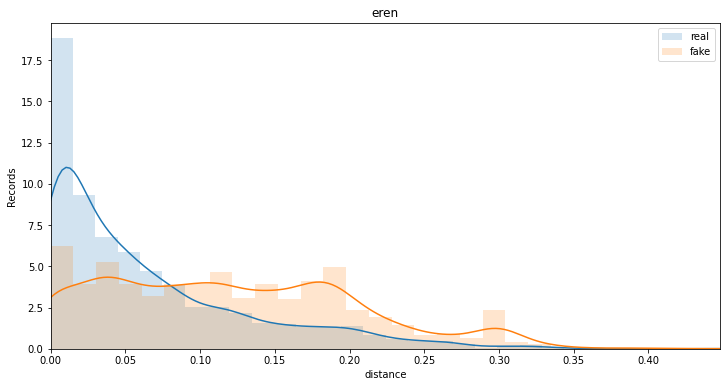

In [1666]:
plot_distance_c(b,a,'eren') ## real od syn od gozlemle
#a['distance'].hist()

/Users/erensmacbook/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/erensmacbook/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


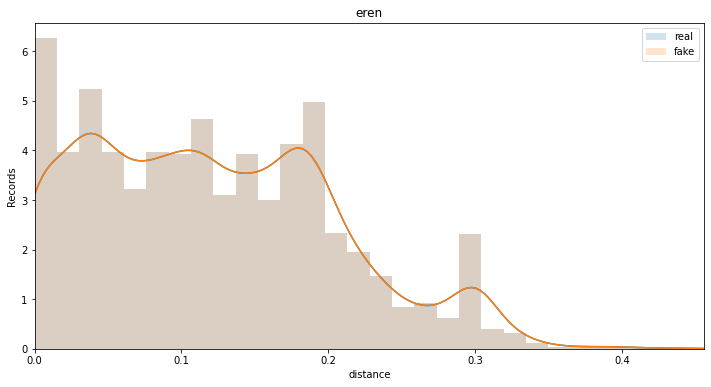

In [1669]:
plot_distance_c(a,a,'eren') ## real od syn od gozlemle


/Users/erensmacbook/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/erensmacbook/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


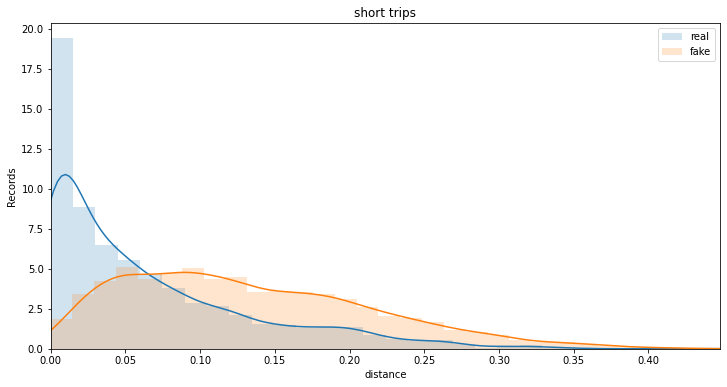

In [1704]:
plot_distance_c(b2,a2,'short trips')

/Users/erensmacbook/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/erensmacbook/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


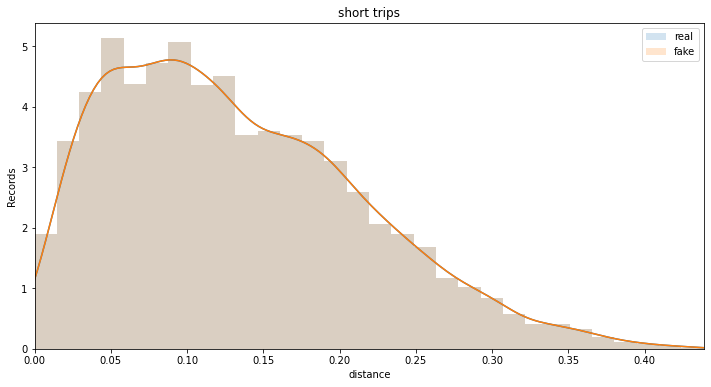

In [1693]:
plot_distance_c(a2,a2,'short trips')

/Users/erensmacbook/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/erensmacbook/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


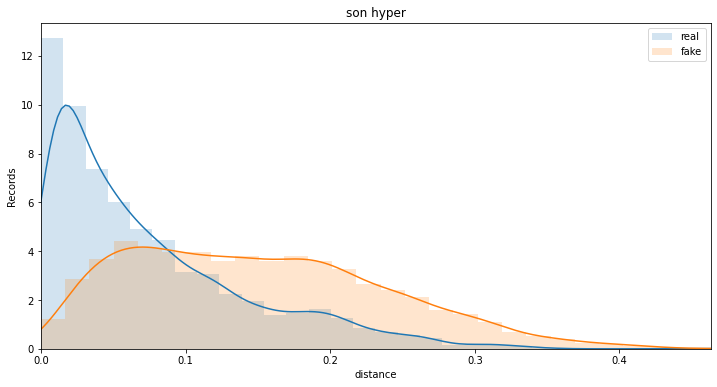

In [358]:
plot_distance_c(b,a,'son hyper') ## real od syn od gozlemle


/Users/erensmacbook/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/erensmacbook/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


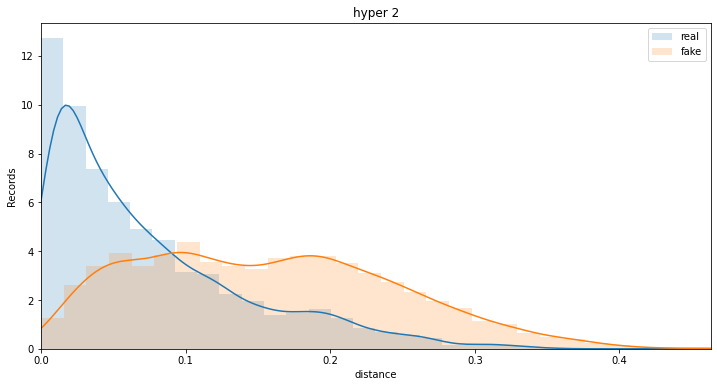

In [381]:
plot_distance_c(b,a,'hyper 2')

In [386]:
########   ########    ########                                                     ########   ########    ########        
########   ########    ########                                                     ########   ########    ########        
########   ########    ########                                                     ########   ########    ########  


########   ########    ########           Textgenrnn results                        ########   ########    ########        


########   ########    ########                                                     ########   ########    ########        
########   ########    ########                                                     ########   ########    ########   
########   ########    ########                                                     ########   ########    ########        






In [486]:

rnn_sample1= pd.read_csv('rnn_sample1.csv',index_col=0)
rnn_sample2= pd.read_csv('rnn_sample2.csv',index_col=0)


In [473]:
#rnn_sample2['3'] = rnn_sample2['3'].astype(str)
#rnn_sample2['3']=rnn_sample2['3'].apply(lambda x: x.replace('.0',''))
#rnn_sample2['3']=rnn_sample2['3'].astype(int)

In [542]:
rnn_sample3= pd.read_csv('rnn_sample3.csv',index_col=0)
rnn_sample4= pd.read_csv('rnn_sample4.csv',index_col=0)


In [495]:
def gen_od(train_short):
    real_od = pd.DataFrame()
    dests_t=[]
    rang = range(0,len(train_short))
    
    for i in rang:
        hm=train_short.loc[i].tolist()
        ind=np.max( np.nonzero( train_short.loc[i].tolist()))
        if hm[ind] == hm[0]:
            dests_t.append(hm[ind-1])
        else:
            dests_t.append(hm[ind])
    
    real_od['ORIGSA1_2021'] = train_short['0']
    real_od['DESTSA1_2021'] = dests_t
    
    return real_od

    

In [498]:
rnn_od1=gen_od(rnn_sample1)

In [499]:
rnn_dist1= generate_distance(rnn_od1)

/Users/erensmacbook/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [506]:
rnn_sample2=rnn_sample2.reset_index()
rnn_od2=gen_od(rnn_sample2)
rnn_dist2= generate_distance(rnn_od2)

/Users/erensmacbook/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


/Users/erensmacbook/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/erensmacbook/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


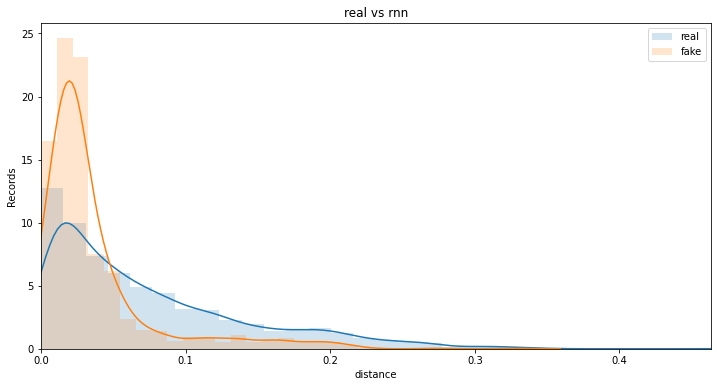

In [527]:
plot_distance_c(b,rnn_dist1,'real vs rnn')

/Users/erensmacbook/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/erensmacbook/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


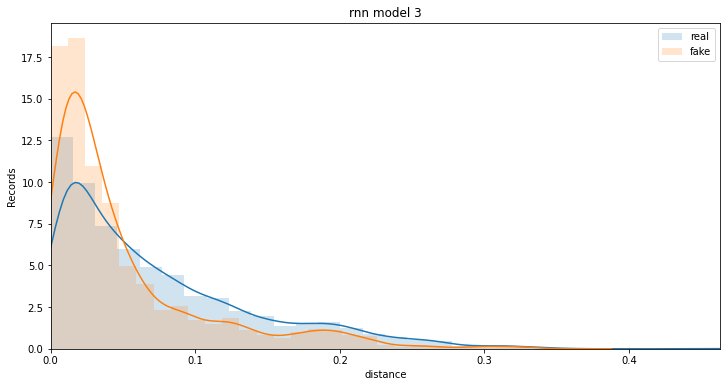

In [541]:
plot_distance_c(b,rnn_dist3,'rnn model 3')

/Users/erensmacbook/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/erensmacbook/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


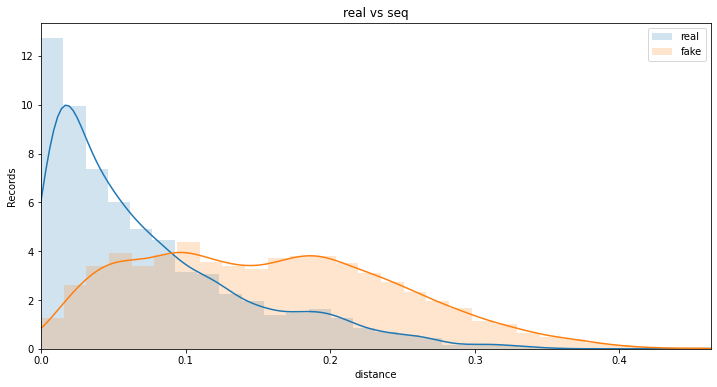

In [529]:
plot_distance_c(b,a,'real vs seq')

/Users/erensmacbook/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/erensmacbook/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


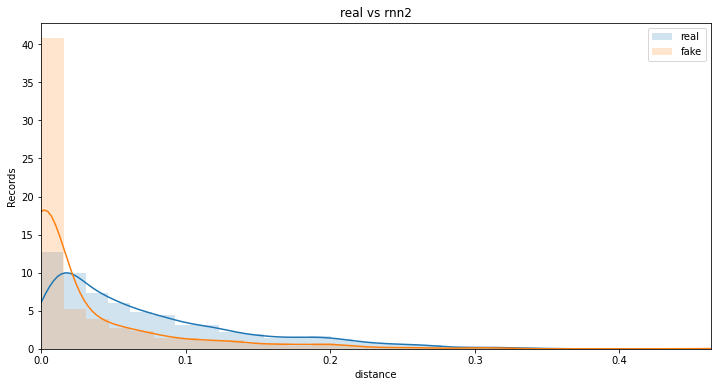

In [528]:
plot_distance_c(b,rnn_dist2,'real vs rnn2')

/Users/erensmacbook/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/erensmacbook/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


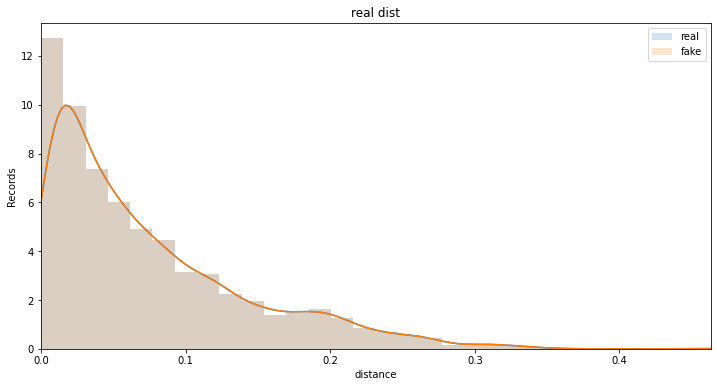

In [526]:
plot_distance_c(b,b,'real dist')

/Users/erensmacbook/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/erensmacbook/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


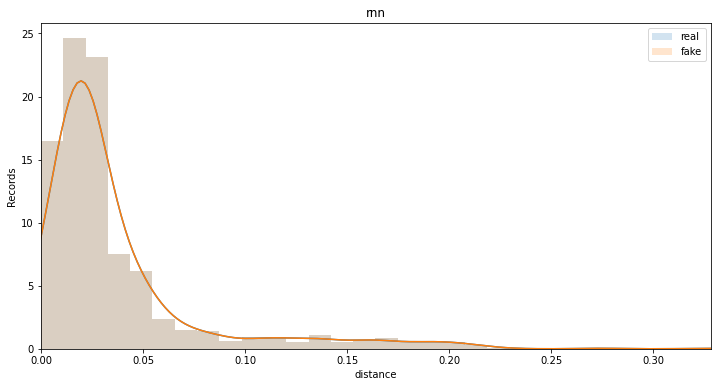

In [525]:
plot_distance_c(rnn_dist1,rnn_dist1,'rnn')


/Users/erensmacbook/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/erensmacbook/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


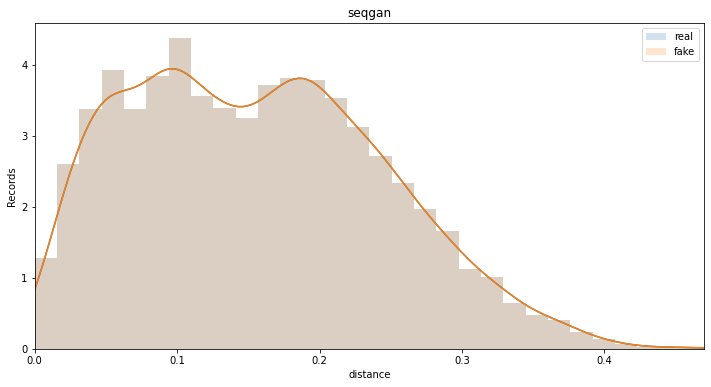

In [524]:
plot_distance_c(a,a,'seqgan')


In [530]:
rnn_sample3= pd.read_csv('rnn_sample3.csv',index_col=0)


In [535]:
rnn_od3= gen_od(rnn_sample3)

In [537]:
rnn_dist3=generate_distance(rnn_od3)

/Users/erensmacbook/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [ ]:
# ctgan icin origin home destination main activity en cok vakit

# rnn icin origin destination en uzak 

# shortest path - validation 

In [548]:
rnn_od4=gen_od(rnn_sample4)
rnn_dist4=generate_distance(rnn_od4)

/Users/erensmacbook/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


/Users/erensmacbook/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/erensmacbook/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


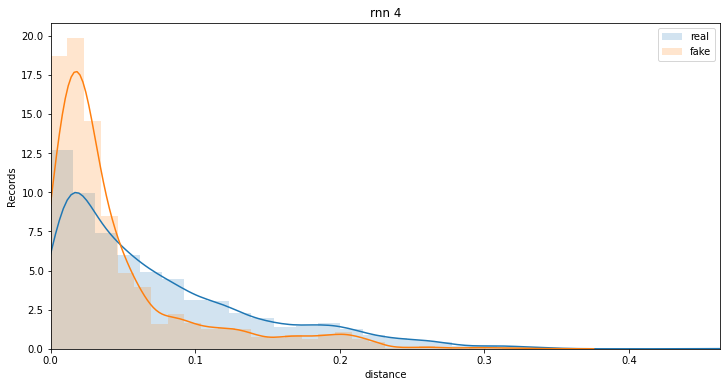

In [550]:
plot_distance_c(b,rnn_dist4,'rnn 4')


In [603]:
rnn_sample5= pd.read_csv('rnn_sample5.csv',index_col=0)


/Users/erensmacbook/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/Users/erensmacbook/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/erensmacbook/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for hi

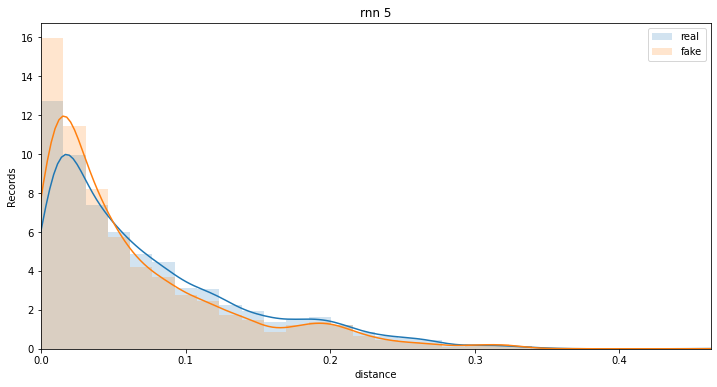

In [606]:
rnn_od5=gen_od(rnn_sample5)
rnn_dist5=generate_distance(rnn_od5)
plot_distance_c(b,rnn_dist5,'rnn 5') ### 0.8 tempature 


In [619]:
rnn_sample6= pd.read_csv('rnn_sample6.csv',index_col=0)


/Users/erensmacbook/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/Users/erensmacbook/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/erensmacbook/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for hi

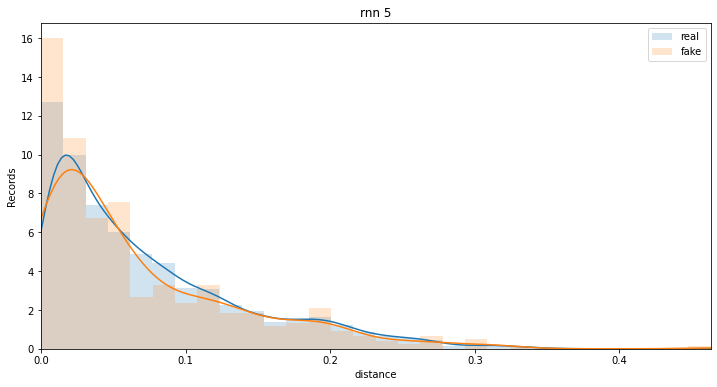

In [622]:
rnn_od6=gen_od(rnn_sample6)
rnn_dist6=generate_distance(rnn_od6)
plot_distance_c(b,rnn_dist6,'rnn 5') ### 0.8 tempature 


In [ ]:
def generate_distance_hops(syn_data):
    
    cols = syn_data.columns()
    
    for i in cols:
        syn_data=pd.merge(syn_data,qld_orig, on=i)
    
    
    return syn_data

In [874]:
merger=rnn_sample6.copy()
#merger["0"]=qld_orig.ORIGSA1_2021
#merger["1"]=qld_orig.ORIGSA1_2021
#merger["2"]=qld_orig.ORIGSA1_2021
#merger["3"]=qld_orig.ORIGSA1_2021
merger


,0,1,2,3
0,30501110703,30503111913,30501110703,0
1,30102101107,30101100434,30101100407,30101100407
2,30203104025,30102101212,30203104025,0
3,30202102731,30501110536,30202102731,0
4,30303106103,30202103005,30303106103,0
...,...,...,...,...
495,30303106222,30303106511,30303106341,30303106020
496,30101100115,30101100112,30101100115,0
497,30101100408,30101100442,30101100408,0
498,30402109001,30402109007,30403109418,30403109416


In [696]:
#rnn_sample4['dist1'] 
area_dict = dict(zip(qld_orig.ORIGSA1_2021, qld_orig.geo_o))
area_dict[0]=0

In [875]:
generate_merger(merger)

/Users/erensmacbook/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1990: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
/Users/erensmacbook/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


,index,0,1,2,3,geo_0,geo_1,geo_2,geo_3,xo_0,...,yo_2,xo_3,yo_3,pt_0,pt_1,pt_2,pt_3,distance01,distance12,distance23
0,0,30501110703,30503111913,30501110703,0,POLYGON ((153.0131179834931 -27.48570548388386...,POLYGON ((153.04074902709252 -27.4336834462463...,POLYGON ((153.0131179834931 -27.48570548388386...,0,153.014513,...,-27.486054,0.000000,0.000000,POINT (153.01451258816073 -27.486053908960574),POINT (153.0437421764672 -27.43609556127661),POINT (153.01451258816073 -27.486053908960574),POINT (0 0),0.057881,0.057881,0.000000
1,1,30102101107,30101100434,30101100407,30101100407,POLYGON ((153.18047366515415 -27.5673846213758...,POLYGON ((153.18348611889118 -27.5354424714277...,POLYGON ((153.18939518017535 -27.5203444219053...,POLYGON ((153.18939518017535 -27.5203444219053...,153.189913,...,-27.519894,153.195450,-27.519894,POINT (153.1899128190817 -27.56858148759736),POINT (153.18597936346077 -27.53619024190829),POINT (153.19545009494112 -27.51989394269133),POINT (153.19545009494112 -27.51989394269133),0.032629,0.018848,0.000000
2,2,30203104025,30102101212,30203104025,0,POLYGON ((153.07026632786378 -27.4025404589664...,POLYGON ((153.26791294816852 -27.5483954600715...,POLYGON ((153.07026632786378 -27.4025404589664...,0,153.071446,...,-27.403310,0.000000,0.000000,POINT (153.07144609749287 -27.403310363985835),POINT (153.26813404294407 -27.550400449872484),POINT (153.07144609749287 -27.403310363985835),POINT (0 0),0.245605,0.245605,0.000000
3,3,30202102731,30501110536,30202102731,0,POLYGON ((153.0055866588997 -27.36982925221172...,POLYGON ((153.02605748454576 -27.4663523150294...,POLYGON ((153.0055866588997 -27.36982925221172...,0,153.008605,...,-27.370513,0.000000,0.000000,POINT (153.00860500852485 -27.370513432286128),POINT (153.02607252438253 -27.468334445134868),POINT (153.00860500852485 -27.370513432286128),POINT (0 0),0.099368,0.099368,0.000000
4,4,30303106103,30202103005,30303106103,0,POLYGON ((153.07252601747606 -27.5618804604533...,POLYGON ((153.04024504445246 -27.3757424857371...,POLYGON ((153.07252601747606 -27.5618804604533...,0,153.074436,...,-27.559713,0.000000,0.000000,POINT (153.07443604731785 -27.559712935521816),POINT (153.04131328911188 -27.37768788577783),POINT (153.07443604731785 -27.559712935521816),POINT (0 0),0.185014,0.185014,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481,495,30303106222,30303106511,30303106341,30303106020,POLYGON ((153.10801796674494 -27.5374950538325...,POLYGON ((153.07897837665237 -27.5628962611103...,POLYGON ((153.07919799939359 -27.5410624409599...,POLYGON ((153.07588401548088 -27.5747774608928...,153.112494,...,-27.540822,153.078131,-27.575811,POINT (153.11249443082804 -27.540688519065053),POINT (153.08302414599285 -27.564165946673064),POINT (153.0797290043028 -27.54082171609536),POINT (153.07813145007808 -27.57581095608465),0.037679,0.023576,0.035026
482,496,30101100115,30101100112,30101100115,0,POLYGON ((153.2215888671507 -27.51694647513297...,POLYGON ((153.22068888662224 -27.5218584950807...,POLYGON ((153.2215888671507 -27.51694647513297...,0,153.221808,...,-27.516802,0.000000,0.000000,POINT (153.22180759728369 -27.51680193503271),POINT (153.22327999128123 -27.522364970350772),POINT (153.22180759728369 -27.51680193503271),POINT (0 0),0.005755,0.005755,0.000000
483,497,30101100408,30101100442,30101100408,0,POLYGON ((153.2021659089905 -27.51887664318428...,POLYGON ((153.1915058585793 -27.53111643220376...,POLYGON ((153.2021659089905 -27.51887664318428...,0,153.202971,...,-27.520047,0.000000,0.000000,POINT (153.20297060353653 -27.520047463365334),POINT (153.1935689179926 -27.533678492544823),POINT (153.20297060353653 -27.520047463365334),POINT (0 0),0.016559,0.016559,0.000000
484,498,30402109001,30402109007,30403109418,30403109416,POLYGON ((152.94653197693495 -27.5151934174446...,POLYGON ((152.94266597707315 -27.5174004170752...,POLYGON ((152.96149103624174 -27.5079184488846...,POLYGON ((152.97400702625166 -27.4971564400531...,152.

In [892]:
def generate_merger(df):
    
    merger=df.copy()
    
    merger['geo_0']=merger['0'].map(area_dict)
    merger['geo_1']=merger['1'].map(area_dict)
    merger['geo_2']=merger['2'].map(area_dict)
    merger['geo_3']=merger['3'].map(area_dict)

    merger = merger.dropna().reset_index()

    merger['xo_0'] = merger["geo_0"].apply(lambda x: (x.bounds[0]+x.bounds[2]) /2 if x !=0 else 0 )
    merger['yo_0'] = merger["geo_0"].apply(lambda x: (x.bounds[1]+x.bounds[3]) /2 if x !=0 else 0 )

    merger['xo_1'] = merger["geo_1"].apply(lambda x: (x.bounds[0]+x.bounds[2]) /2 if x !=0 else 0 )
    merger['yo_1'] = merger["geo_1"].apply(lambda x: (x.bounds[1]+x.bounds[3]) /2 if x !=0 else 0 )

    merger['xo_2'] = merger["geo_2"].apply(lambda x: (x.bounds[0]+x.bounds[2]) /2 if x !=0 else 0 ) 
    merger['yo_2'] = merger["geo_2"].apply(lambda x: (x.bounds[1]+x.bounds[3]) /2 if x !=0 else 0 )

    merger['xo_3'] = merger["geo_3"].apply(lambda x: (x.bounds[0]+x.bounds[2]) /2 if x !=0 else 0 )
    merger['yo_3'] = merger["geo_3"].apply(lambda x: (x.bounds[1]+x.bounds[3]) /2 if x !=0 else 0 )

    merger['pt_0']=merger.apply(lambda x: Point((x['xo_0'],x['yo_0'])) ,axis=1 )
    merger['pt_1']=merger.apply(lambda x: Point((x['xo_1'],x['yo_1'])) ,axis=1 )
    merger['pt_2']=merger.apply(lambda x: Point((x['xo_2'],x['yo_2'])) ,axis=1 )
    merger['pt_3']=merger.apply(lambda x: Point((x['xo_3'],x['yo_3'])) ,axis=1 )

    merger['distance01']=merger.apply(lambda x: 0 if x['pt_1'] ==  Point(0 ,0) else (x['pt_0'].distance(x['pt_1'])) ,axis=1 )
    merger['distance12']=merger.apply(lambda x: 0 if x['pt_2'] ==  Point(0 ,0) else (x['pt_1'].distance(x['pt_2'])) ,axis=1 )
    merger['distance23']=merger.apply(lambda x: 0 if x['pt_3'] ==  Point(0 ,0) else (x['pt_2'].distance(x['pt_3'])) ,axis=1 )
    
    return merger



In [895]:

def add_distance(merger):
    merg_dist= merger[['distance01','distance12','distance23']].idxmax(axis = 1)

    distances =[]
    for i in range(len(merger)):
        indeks=merg_dist[i]

        if indeks == 'distance01':
            distances.append(merger['distance01'].iloc[i])
    
        elif indeks =='distance12':
            distances.append(merger['distance12'].iloc[i])

    
        elif indeks=='distance23':
            distances.append(merger['distance23'].iloc[i])
            
    merger['distance']=distances

    

In [894]:
merger=generate_merger(merger)

/Users/erensmacbook/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1990: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
/Users/erensmacbook/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [902]:
real_merger=generate_merger(train_short)

/Users/erensmacbook/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1990: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
/Users/erensmacbook/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [905]:
add_distance(real_merger)

/Users/erensmacbook/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/erensmacbook/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


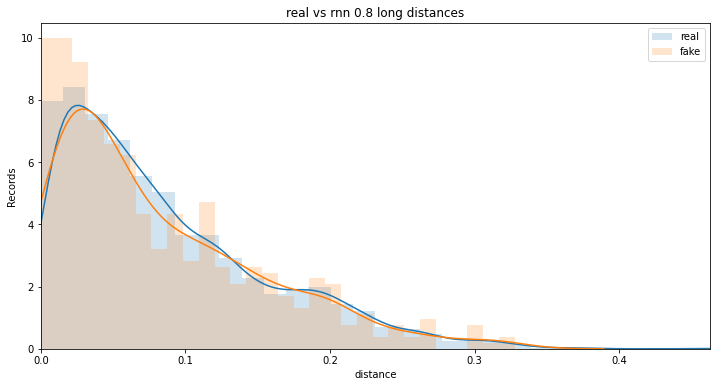

In [907]:
plot_distance_c(real_merger,merger,'real vs rnn 0.8 long distances') ### 0.8 tempature 


In [914]:
merger5=generate_merger(rnn_sample5)
add_distance(merger5)


/Users/erensmacbook/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1990: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
/Users/erensmacbook/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


NameError: name 'merge5' is not defined

/Users/erensmacbook/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/erensmacbook/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


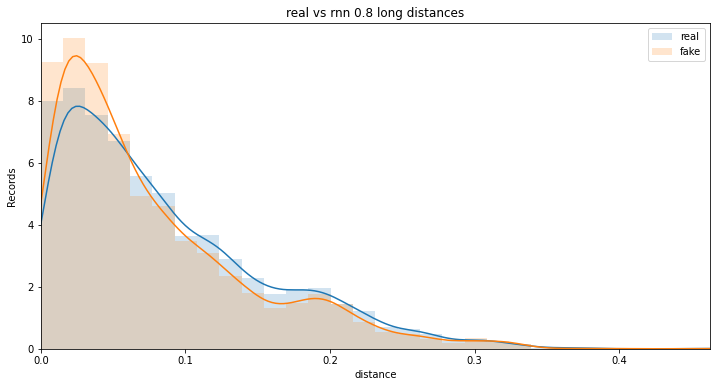

In [916]:
plot_distance_c(real_merger,merger5,'real vs rnn 0.8 long distances') ### 0.8 tempature 


In [1045]:
#train_seq.loc[:,'0':'4'].ne(0)
cols=syn_seq.columns
syn_seq[cols] = syn_seq[cols].replace({'1578':np.nan, 1578:np.nan})
#train_seq[cols] = train_seq[cols].replace({'0':np.nan, 0:np.nan})

In [1046]:
syn_seq[0:10]

,0,1,2,3,4,5,6
0,17.0,340.0,NaN,NaN,NaN,NaN,NaN
1,777.0,526.0,NaN,NaN,NaN,NaN,NaN
2,218.0,630.0,46.0,NaN,NaN,NaN,NaN
3,743.0,1373.0,NaN,NaN,NaN,NaN,NaN
4,503.0,379.0,NaN,NaN,NaN,NaN,NaN
5,390.0,726.0,843.0,NaN,NaN,NaN,NaN
6,521.0,809.0,NaN,NaN,NaN,NaN,NaN
7,1566.0,1233.0,NaN,NaN,NaN,NaN,NaN
8,252.0,191.0,845.0,NaN,NaN,NaN,NaN
9,300.0,1429.0,NaN,NaN,NaN,NaN,NaN


In [1049]:
#syn_seq.fillna(method='ffill', axis=1).iloc[:, -1]


In [1420]:
res_str = dict((str(k),str(v)) for k,v in res.items())
## new dict

In [1202]:
syn_od = pd.DataFrame()
real_od = pd.DataFrame()

syn_od['ORIGSA1_2021'] =syn_seq['0']
syn_od['DESTSA1_2021'] =syn_seq.fillna(method='ffill', axis=1).iloc[:, -1]

#real_od['ORIGSA1_2021'] =train_seq['0']
#real_od['DESTSA1_2021'] =train_seq.fillna(method='ffill', axis=1).iloc[:, -2]


""


In [1205]:
syn_od['ORIGSA1_2021'] = syn_od['ORIGSA1_2021'].astype(str).apply(lambda x: x.replace('.0',''))
syn_od['DESTSA1_2021'] = syn_od['DESTSA1_2021'].astype(str).apply(lambda x: x.replace('.0',''))


In [1206]:
#real_od['ORIGSA1_2021'] = cop['ORIGSA1_2021'].map(res)
syn_od['ORIGSA1_2021'] = cop['ORIGSA1_2021'].map(res)

#real_od['DESTSA1_2021'] = cop['ORIGSA1_2021'].map(res)
#syn_od['DESTSA1_2021'] = cop['ORIGSA1_2021'].map(res)


In [1207]:
#syn_od['DESTSA1_2021'] = cop['DESTSA1_2021'].map(dict_with_ints)
syn_od['DESTSA1_2021']=syn_od['DESTSA1_2021'].map(res_str)       # note: if the dictionary does not exhaustively map all


In [1208]:
syn_od

,ORIGSA1_2021,DESTSA1_2021
0,3.050411e+10,30103102108
1,3.050111e+10,30203103920
2,3.050111e+10,30101100302
3,3.050111e+10,30503111909
4,3.050111e+10,30201102420
...,...,...
5307,3.030110e+10,30501111235
5308,3.010110e+10,30306107918
5309,3.010110e+10,30501110612
5310,3.010110e+10,30504113420


In [1209]:
train_seq

,0,1,2,3,4,5,6
0,1107,1216,1284,1578,1578,1578,1578
1,275,1337,619,1337,275,73,275
2,275,284,275,277,275,284,275
3,275,781,284,275,1578,1578,1578
4,275,839,275,1578,1578,1578,1578
...,...,...,...,...,...,...,...
5332,275,321,270,275,1578,1578,1578
5333,275,273,275,332,275,273,275
5334,275,332,275,283,275,1270,663
5335,275,1270,663,275,1578,1578,1578


In [1210]:

train_seq2[cols] = train_seq2[cols].replace({'0':np.nan, 0:np.nan})

/Users/erensmacbook/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [1211]:
train_seq2

,0,1,2,3,4,5,6
0,1107,1216,NaN,NaN,NaN,NaN,NaN
1,275,1337,619,1337,275,73,NaN
2,275,284,275,277,275,284,275
3,275,781,284,NaN,NaN,NaN,NaN
4,275,839,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
5351,275,321,270,NaN,NaN,NaN,NaN
5352,275,273,275,332,275,273,NaN
5353,275,332,275,283,275,1270,663
5354,275,1270,663,NaN,NaN,NaN,NaN


In [1212]:
real_od['ORIGSA1_2021'] =train_seq2['0']
real_od['DESTSA1_2021'] =train_seq2.fillna(method='ffill', axis=1).iloc[:, -1]


In [1213]:
real_od['ORIGSA1_2021'] = cop['ORIGSA1_2021'].map(res)
real_od['DESTSA1_2021']=real_od['DESTSA1_2021'].map(res_str)       # note: if the dictionary does not exhaustively map all


In [1195]:
#syn_od=syn_od.dropna()
#real_od=real_od.dropna()

In [1221]:
real_od['ORIGSA1_2021'] = real_od['ORIGSA1_2021'].astype(str).apply(lambda x: x.replace('.0',''))


/var/folders/jv/2_fp3b717yl0vd8xbytqhz300000gn/T/ipykernel_12626/1001525647.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_od['ORIGSA1_2021'] = real_od['ORIGSA1_2021'].astype(str).apply(lambda x: x.replace('.0',''))


In [1197]:
syn_od=syn_od.dropna()
real_od=real_od.dropna()

In [1198]:

real_od['DESTSA1_2021']=real_od['DESTSA1_2021'].astype(int)
syn_od['DESTSA1_2021']=syn_od['DESTSA1_2021'].astype(int)

/var/folders/jv/2_fp3b717yl0vd8xbytqhz300000gn/T/ipykernel_12626/3712584731.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syn_od['DESTSA1_2021']=syn_od['DESTSA1_2021'].astype(int)


In [1216]:
real_od['ORIGSA1_2021']= real_od['ORIGSA1_2021'].astype(float)
real_od=real_od.dropna()
real_od['ORIGSA1_2021']= real_od['ORIGSA1_2021'].astype(int)

#real_od['ORIGSA1_2021'] = real_od['ORIGSA1_2021'].astype(str).apply(lambda x: x.replace('.0',''))
syn_od['ORIGSA1_2021']= syn_od['ORIGSA1_2021'].astype(float)
syn_od=real_od.dropna()
syn_od['ORIGSA1_2021']= syn_od['ORIGSA1_2021'].astype(int)


/var/folders/jv/2_fp3b717yl0vd8xbytqhz300000gn/T/ipykernel_12626/3786688436.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_od['ORIGSA1_2021']= real_od['ORIGSA1_2021'].astype(int)


In [1219]:
real_od

,ORIGSA1_2021,DESTSA1_2021
0,30504113303,30501110537
1,30501110519,30101100407
2,30501110532,30103101509
3,30501110901,30103101601
4,30501111204,30303106525
...,...,...
5351,30102100722,30103101401
5352,30303106103,30103101505
5353,30203103807,30301105142
5354,30103102014,30301105142


In [317]:
def generate_distance(syn_data):
    syn_data = pd.merge(syn_data,qld_orig, on="ORIGSA1_2021")
    syn_data = pd.merge(syn_data,qld_dest, on="DESTSA1_2021")
    
    syn_data['xo_c'] = syn_data["geo_o"].apply(lambda x: (x.bounds[0]+x.bounds[2]) /2)
    syn_data['yo_c'] = syn_data["geo_o"].apply(lambda x: (x.bounds[1]+x.bounds[3]) /2)

    syn_data['xd_c'] = syn_data["geo_d"].apply(lambda x: (x.bounds[0]+x.bounds[2]) /2)
    syn_data['yd_c'] = syn_data["geo_d"].apply(lambda x: (x.bounds[1]+x.bounds[3]) /2)
    
    syn_data['orig_pt']=syn_data.apply(lambda x: Point((x['xo_c'],x['yo_c'])) ,axis=1 )
    syn_data['dest_pt']=syn_data.apply(lambda x: Point((x['xd_c'],x['yd_c'])) ,axis=1 )
    syn_data['distance']=syn_data.apply(lambda x: (x['orig_pt'].distance(x['dest_pt'])) ,axis=1 )
    
    return syn_data

In [318]:
b

[1137.0,
 1247.0,
 1317.0,
 279.0,
 1371.0,
 632.0,
 75.0,
 288.0,
 281.0,
 344.0,
 796.0,
 854.0,
 321.0,
 634.0,
 1257.0,
 1314.0,
 1261.0,
 1316.0,
 1246.0,
 1290.0,
 1248.0,
 1339.0,
 756.0,
 1486.0,
 1232.0,
 969.0,
 206.0,
 160.0,
 218.0,
 198.0,
 235.0,
 1325.0,
 1242.0,
 1446.0,
 1292.0,
 1555.0,
 207.0,
 168.0,
 151.0,
 1171.0,
 140.0,
 1251.0,
 1241.0,
 1304.0,
 1308.0,
 1582.0,
 1581.0,
 1288.0,
 194.0,
 1530.0,
 1231.0,
 1534.0,
 1531.0,
 1164.0,
 71.0,
 73.0,
 152.0,
 141.0,
 311.0,
 625.0,
 666.0,
 165.0,
 514.0,
 303.0,
 324.0,
 1298.0,
 1252.0,
 533.0,
 1244.0,
 798.0,
 891.0,
 971.0,
 701.0,
 277.0,
 1128.0,
 1228.0,
 407.0,
 1411.0,
 628.0,
 1389.0,
 517.0,
 1370.0,
 1395.0,
 1361.0,
 635.0,
 1268.0,
 121.0,
 1359.0,
 676.0,
 1365.0,
 626.0,
 633.0,
 1265.0,
 1491.0,
 1494.0,
 1366.0,
 487.0,
 627.0,
 274.0,
 913.0,
 814.0,
 967.0,
 1307.0,
 1318.0,
 916.0,
 901.0,
 1309.0,
 1227.0,
 778.0,
 713.0,
 1272.0,
 1341.0,
 1338.0,
 735.0,
 1319.0,
 1484.0,
 715.0,
 910.0,
 

In [319]:
import geopandas as gpd
from shapely.geometry import Polygon, MultiPoint , Point
from math import ceil
import matplotlib.pyplot as plt
import seaborn as sns



/Users/erensmacbook/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/Users/erensmacbook/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [1605]:
train_seq

,0,1,2,3,4,5,6
0,1107,1216,1284,1578,1578,1578,1578
1,275,1337,619,1337,275,73,275
2,275,284,275,277,275,284,275
3,275,781,284,275,1578,1578,1578
4,275,839,275,1578,1578,1578,1578
...,...,...,...,...,...,...,...
5332,275,321,270,275,1578,1578,1578
5333,275,273,275,332,275,273,275
5334,275,332,275,283,275,1270,663
5335,275,1270,663,275,1578,1578,1578


In [1620]:
syn_seq

,index,0,1,2,3,4,5,6
0,0,NaN,NaN,3.010110e+10,3.010110e+10,3.010110e+10,3.010110e+10,3.010110e+10
1,1,NaN,NaN,3.010110e+10,3.010110e+10,3.010110e+10,3.010110e+10,3.010110e+10
2,2,NaN,NaN,NaN,3.010110e+10,3.010110e+10,3.010110e+10,3.010110e+10
3,3,NaN,NaN,3.010110e+10,3.010110e+10,3.010110e+10,3.010110e+10,3.010110e+10
4,4,NaN,NaN,3.010110e+10,3.010110e+10,3.010110e+10,3.010110e+10,3.010110e+10
...,...,...,...,...,...,...,...,...
5256,5307,NaN,NaN,NaN,3.010110e+10,3.010110e+10,3.010110e+10,3.010110e+10
5257,5308,NaN,NaN,3.010110e+10,3.010110e+10,3.010110e+10,3.010110e+10,3.010110e+10
5258,5309,NaN,NaN,3.010110e+10,3.010110e+10,3.010110e+10,3.010110e+10,3.010110e+10
5259,5310,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1619]:
syn_od

,ORIGSA1_2021,DESTSA1_2021
0,30101100127,30103102108
1,30303106032,30203103920
2,30102101230,30101100302
3,30302105803,30503111909
4,30203103603,30201102420
...,...,...
5256,30203103603,30501111235
5257,30502111310,30306107918
5258,30203103603,30501110612
5259,30503112905,30504113420


In [697]:
def plot_distance(train_data_1,syn_data,title):    
    plt.figure(figsize=(12,6))
    plt.xlim(0,0.1)

    plt.xlabel('Distance')
    plt.ylabel('Records')
    plt.title(title)

    sns.distplot(train_data_1['distance'],bins=30,hist_kws=dict(alpha=0.3),label='real',norm_hist=True)
    sns.distplot(syn_data['distance'],bins=30,hist_kws=dict(alpha=0.3),label='fake',norm_hist=True)

    plt.legend()
    plt.show()


In [322]:
def plot_distance_c(train_data_1,syn_data,title):    
    
    anchor= train_data_1.distance.max()
    plt.figure(figsize=(12,6))
    plt.xlim(0,round(anchor,3))

    plt.xlabel('Distance')
    plt.ylabel('Records')
    plt.title(title)

    sns.distplot(train_data_1['distance'],bins=30,hist_kws=dict(alpha=0.2),label='real')
    sns.distplot(syn_data['distance'],bins=30,hist_kws=dict(alpha=0.2),label='fake')

    plt.legend()
    plt.show()

/Users/erensmacbook/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/erensmacbook/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


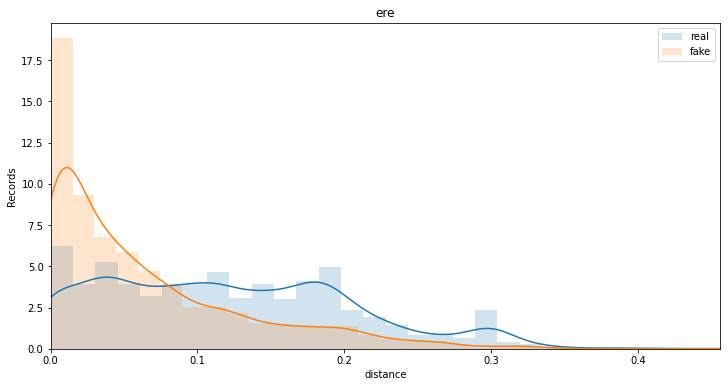

In [1680]:
plot_distance_c(a,b,'ere')

In [1603]:
train_seq

,0,1,2,3,4,5,6
0,1107,1216,1284,1578,1578,1578,1578
1,275,1337,619,1337,275,73,275
2,275,284,275,277,275,284,275
3,275,781,284,275,1578,1578,1578
4,275,839,275,1578,1578,1578,1578
...,...,...,...,...,...,...,...
5332,275,321,270,275,1578,1578,1578
5333,275,273,275,332,275,273,275
5334,275,332,275,283,275,1270,663
5335,275,1270,663,275,1578,1578,1578


In [1616]:
train_seq2

,0,1,2,3,4,5,6
0,30403109418,30501110537,0,0,0,0,0
1,30103101509,30502111409,30301104813,30502111409,30103101509,30101100407,0
2,30103101509,30103101601,30103101509,30103101511,30103101509,30103101601,30103101509
3,30103101509,30303106043,30103101601,0,0,0,0
4,30103101509,30303106525,0,0,0,0,0
...,...,...,...,...,...,...,...
5332,30103101509,30103102002,30103101401,0,0,0,0
5333,30103101509,30103101505,30103101509,30103102031,30103101509,30103101505,0
5334,30103101509,30103102031,30103101509,30103101519,30103101509,30501111001,30301105142
5335,30103101509,30501111001,30301105142,0,0,0,0


In [1636]:
syn_seq

,0,1,2,3,4,5,6
0,30101100127,30103102108,0,0,0,0,0
1,30303106032,30203103920,0,0,0,0,0
2,30102101230,30301104914,30101100302,0,0,0,0
3,30302105803,30503111909,0,0,0,0,0
4,30203103603,30201102420,0,0,0,0,0
...,...,...,...,...,...,...,...
5307,30203103603,30301104817,30501111235,0,0,0,0
5308,30502111310,30306107918,0,0,0,0,0
5309,30203103603,30501110612,0,0,0,0,0
5310,30503112905,30403109418,30401108118,30201102401,30504113230,30503112909,30504113420


/Users/erensmacbook/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/erensmacbook/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


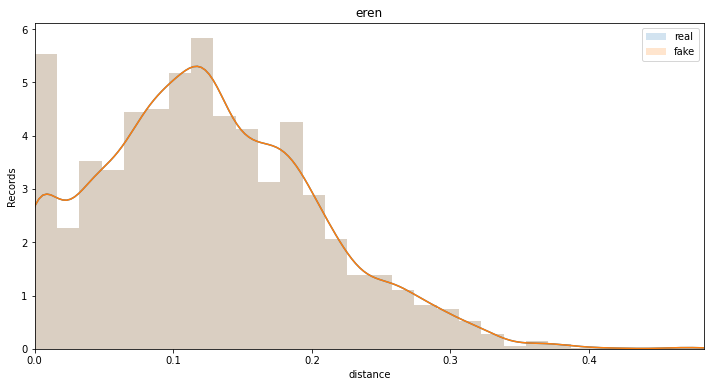

In [1629]:
plot_distance_c(a,a,'eren')

/Users/erensmacbook/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/erensmacbook/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


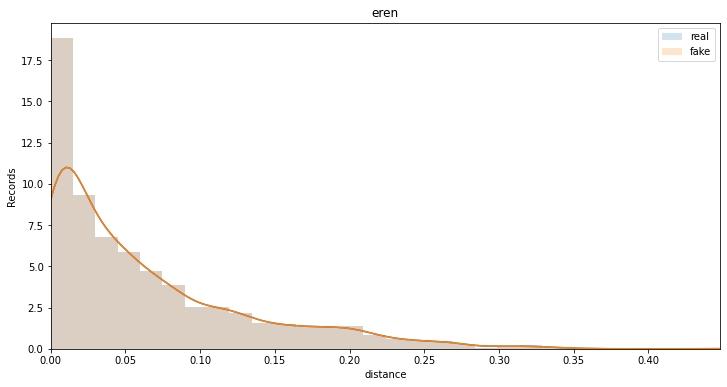

In [1630]:
plot_distance_c(b,b,'eren')

In [178]:
plot_distance_c(a,b,'short')

NameError: name 'plot_distance_c' is not defined

In [710]:

## toplam distance - shortest path 

### ctgan cordinatsal - seq gan 0 diction, kesecegin yeri belirle. map each other

In [1005]:
ea1 = pd.DataFrame()
ea2 = pd.DataFrame()


In [1010]:
ea1['ea1'] = list(range(0,10))
ea2['ea2'] = list(range(20,30))


In [1013]:
ea1['dif'] = ea1['ea1'] -ea2['ea2'] 

In [1609]:
real_od

,ORIGSA1_2021,DESTSA1_2021
0,30403109418,30501110537
1,30103101509,30101100407
2,30103101509,30103101509
3,30103101509,30103101601
4,30103101509,30303106525
...,...,...
5332,30103101509,30103101401
5333,30103101509,30103101505
5334,30103101509,30301105142
5335,30103101509,30301105142
